In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

In [3]:
def RMSLE(y_true, y_pred):
    """
    The Root Mean Squared Log Error (RMSLE) metric

    :param y_true: The ground truth labels given in the dataset
    :param y_pred: Our predictions

    :return: The RMSLE score
    """
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [4]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

test_ids = test["id"]

In [5]:
train.head()

,age,sex,bmi,children,smoker,region,charges,id
0,43,male,26.030,0,no,northeast,6837.36870,1
1,58,female,28.215,0,no,northwest,12224.35085,2
2,53,male,31.350,0,no,southeast,27346.04207,3
3,54,male,29.200,1,no,southwest,10436.09600,4
4,19,male,34.900,0,yes,southwest,34828.65400,5


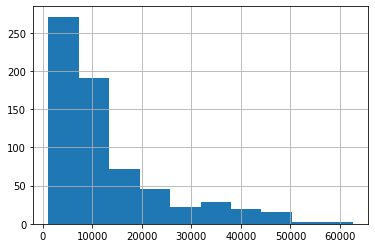

In [6]:
train["charges"].hist();

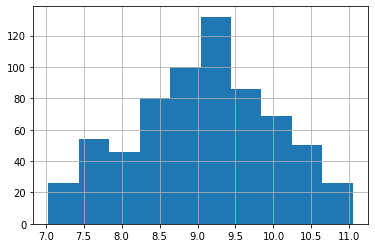

In [7]:
np.log1p(train["charges"]).hist();

In [8]:
# Целевая переменная

train_y = train["charges"]
train.drop(["charges"], axis=1, inplace=True)

In [9]:
train.drop(["id"], axis=1, inplace=True)
test.drop(["id"], axis=1, inplace=True)

In [10]:
# One-hot encoding для категориальных фичей

train = pd.concat(
    [
        train,
        pd.get_dummies(train[["sex", "region", "smoker"]], drop_first=True),
    ],
    axis=1,
).drop(["sex", "smoker", "region"], axis=1)

test = pd.concat(
    [
        test,
        pd.get_dummies(test[["sex", "region", "smoker"]], drop_first=True),
    ],
    axis=1,
).drop(["sex", "smoker", "region"], axis=1)

In [11]:
train.head()

,age,bmi,children,sex_male,region_northwest,region_southeast,region_southwest,smoker_yes
0,43,26.030,0,1,0,0,0,0
1,58,28.215,0,0,1,0,0,0
2,53,31.350,0,1,0,1,0,0
3,54,29.200,1,1,0,0,1,0
4,19,34.900,0,1,0,0,1,1


In [12]:
test.head()

,age,bmi,children,sex_male,region_northwest,region_southeast,region_southwest,smoker_yes
0,45,25.175,2,0,0,0,0,0
1,36,30.020,0,0,1,0,0,0
2,64,26.885,0,0,1,0,0,1
3,46,25.745,3,1,1,0,0,0
4,19,31.920,0,1,1,0,0,1


In [13]:
def cv_and_predict(
    df_train,
    df_test,
    train_y,
    model,
    log_transform_target=True,
    do_scaling=True,
    n_splits=5,
    random_state=42,
    verbose=True,
):
    """
    Функция для кросс-валидации и предикта на тест

    :param df_train: Трейн-датафрейм
    :param df_test: Тест-датафрейм
    :param train_y: Ответы на трейн
    :param model: Модель, которую мы хотим учить
    :param log_transform_target: Делаем ли лог-трансформацию таргета при обучении
    :param do_scaling: Делаем ли скейлинг признаков
    :param n_splits: Количество сплитов для KFold
    :param random_state: random_state для KFold
    :param verbose: Делаем ли print'ы

    :return: pred_test: Предсказания на тест; oof_df: OOF предсказания
    """

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # В датафрейме oof_df будут храниться настоящий таргет трейна и OOF предсказания на трейн.
    # Инициализируем prediction_oof нулями и будем заполнять предсказаниями в процессе валидации
    oof_df = pd.DataFrame()
    oof_df["target"] = train_y
    oof_df["prediction_oof"] = np.zeros(oof_df.shape[0])

    # Список с метриками по фолдам
    metrics = []

    # Предсказания на тест. Инициализируем нулями и будем заполнять предсказаниями в процессе валидации.
    # Наши предсказания будут усреднением n_splits моделей
    pred_test = np.zeros(df_test.shape[0])

    # Кросс-валидация
    for i, (train_index, valid_index) in enumerate(kf.split(df_train, train_y)):
        if verbose:
            print(f"fold_{i} started")

        X_train = df_train.loc[train_index]
        y_train = train_y.loc[train_index].values

        if log_transform_target:
            y_train = np.log1p(y_train)

        if do_scaling:
            scaler = StandardScaler()
            columns = X_train.columns
            X_train = scaler.fit_transform(X_train)
            X_train = pd.DataFrame(X_train)
            X_train.columns = columns

        X_valid = df_train.loc[valid_index]
        y_valid = train_y.loc[valid_index].values

        if do_scaling:
            X_valid = scaler.transform(X_valid)
            X_valid = pd.DataFrame(X_valid)
            X_valid.columns = columns

        model_kf = deepcopy(model)

        model_kf.fit(X_train, y_train)

        if do_scaling:
            df_test_scaled = scaler.transform(df_test)
            df_test_scaled = pd.DataFrame(df_test_scaled)
            df_test_scaled.columns = columns
            prediction_kf = model_kf.predict(df_test_scaled)
        else:
            prediction_kf = model_kf.predict(df_test)

        if log_transform_target:
            prediction_kf = np.expm1(prediction_kf)

        pred_test += prediction_kf / n_splits

        prediction = model_kf.predict(X_valid)

        if log_transform_target:
            prediction = np.expm1(prediction)
        oof_df.loc[valid_index, "prediction_oof"] = prediction

        cur_metric = RMSLE(y_valid, prediction)
        metrics.append(cur_metric)
        if verbose:
            print(f"metric_{i}: {cur_metric}")
            print()
            print("_" * 100)
            print()

    metric_OOF = RMSLE(train_y, oof_df["prediction_oof"])

    if verbose:
        print(f"metric_OOF: {metric_OOF}")
        print(f"metric_AVG: {np.mean(metrics)}")
        print(f"metric_std: {np.std(metrics)}")
        print()
        print("*" * 100)
        print()

    return pred_test, oof_df, metric_OOF

In [14]:
# Найдем оптимальный n_neighbors

metric_list = []
MAX_NEIGHBORS = 30
n_neighbors_list = list(range(1, MAX_NEIGHBORS))

for n_neighbors in tqdm(n_neighbors_list, desc="n_neighbors search"):
    model_knn = KNeighborsRegressor(
        n_neighbors=n_neighbors, n_jobs=4, weights="distance"
    )
    pred_test, oof_df, metric_OOF = cv_and_predict(
        train, test, train_y, model_knn, n_splits=2, verbose=False
    )
    metric_list.append(metric_OOF)

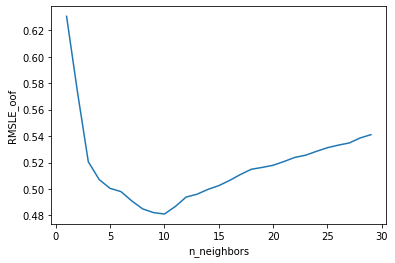

In [15]:
plt.plot(n_neighbors_list, metric_list);
plt.xlabel("n_neighbors");
plt.ylabel("RMSLE_oof");

In [16]:
min_metric, best_n_neighbors_idx = min(
    (val, idx) for (idx, val) in enumerate(metric_list)
)
best_n_neighbors = n_neighbors_list[best_n_neighbors_idx]

In [17]:
best_n_neighbors

10

In [18]:
model_knn = KNeighborsRegressor(
    n_neighbors=best_n_neighbors, n_jobs=4, weights="distance"
)

In [19]:
%%time

pred_test, oof_df, metric_OOF = cv_and_predict(train, test, train_y, model_knn, n_splits=2)

fold_0 started
metric_0: 0.48511108248843116

____________________________________________________________________________________________________

fold_1 started
metric_1: 0.4769493656706545

____________________________________________________________________________________________________

metric_OOF: 0.4810536335922347
metric_AVG: 0.4810302240795428
metric_std: 0.004080858408888333

****************************************************************************************************

CPU times: user 123 ms, sys: 19.1 ms, total: 142 ms
Wall time: 445 ms


In [20]:
# Сравним OOF предсказания с константным бейзлайном и убедимся, что мы лучше

best_constant = np.expm1(np.mean(np.log1p(train_y)))
constant_baseline = np.ones(oof_df.shape[0]) * best_constant
RMSLE(constant_baseline, oof_df["target"])

0.9048047411379614

In [21]:
submission = pd.DataFrame()
submission["id"] = test_ids
submission["charges"] = pred_test

In [22]:
submission.head()

,id,charges
0,770,8856.517856
1,771,4586.774504
2,772,24149.689937
3,773,8522.619868
4,774,22522.729460


In [23]:
submission.to_csv("submission_knn_n_splits_2.csv", index=False)